In [1]:
#%quickref
%qtconsole

In [9]:
# Load the files for scanning
from matplotlib.pyplot import imshow
import glob, os

target_path = os.path.realpath(os.path.join(os.getcwd(), "../testimages"))

print ("Scan for files in {}".format(target_path));

files = glob.glob(os.path.join(target_path, '*.jpg'));
print ("Found {} files".format(len(files)))

# .. for now we assume all are images

Scan for files in /home/ruben/Documents/Projecten/2017/ALLES WAT IK VOEL/testimages
Found 14 files


In [10]:
# load as PIL Images
from PIL import Image
images = [Image.open(file) for file in files]

In [11]:
import numpy as np

arrays = [np.array(image) for image in images]

In [12]:
def getChannelImagesFromImage(arrImg):
    """
    [(255,255,255)] => ( [(255,0,0)], [(0,255,0)], [(0,0,255)] )
    Three separate images that show individual channels
    """
    red = arrImg.copy()
    red[:,:,1] = 0
    red[:,:,2] = 0

    green = arrImg.copy()
    green[:,:,0] = 0
    green[:,:,2] = 0

    blue = arrImg.copy()
    blue[:,:,0] = 0
    blue[:,:,1] = 0
    return (red, green, blue)

# (red,green,blue) = getChannelImagesFromImage(arrays[0])
# print (red)
# images[0].show()
# Image.fromarray(red).show()
# Image.fromarray(green).show()
# Image.fromarray(blue).show()

In [13]:
def getImageAsHSV(image):
    hsv = np.array(image.convert('HSV'))

#     If you want to get individual channels use
#     hue = hsv[:,:,0]
#     sat = hsv[:,:,1]
#     val = hsv[:,:,2]

#     hue = hsv.copy()
#     hsv[:,:,0] = 255 #all hue to 100%
#     hsv[:,:,1] = 255 #all saturation to 100%
#     hsv[:,:,2] = 255 #all brightness to 100%
    return hsv

# hue_img = Image.fromarray(getImageAsHSV(images[4]), mode="HSV")

# %matplotlib inline
# imshow(np.asarray(hue_img.convert('RGB')))

452 640 3


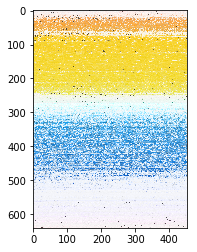

In [14]:
# sorting pixels by hue
# http://stackoverflow.com/a/2828121
# Sort by column: a[a[:,1].argsort()]
hsv = np.array(images[4].convert('HSV'))
print (len(hsv), len(hsv[0]), len(hsv[0,0]))
height = len(hsv)
singleLine = np.concatenate(hsv)
sortedLine = np.array(sorted(singleLine, key=lambda pixel: pixel[0])) # change pixel[0] to 1 or 2 for saturation & brightness
sortedImage = sortedLine.reshape(int(len(sortedLine)/height), height, 3)

sortedImg = Image.fromarray(sortedImage, mode="HSV")

sortedImg.show()

%matplotlib inline
imshow(np.asarray(sortedImg.convert('RGB')))

Total 289280


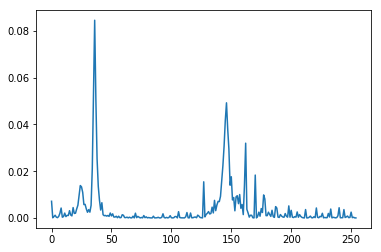

In [16]:
import scipy
hues = np.zeros(255)

# Get the spread of hue in an image
# for image in images:
image = images[4]
hsv = np.array(image.convert('HSV'))
hue = hsv[:,:,0]
print("Total %s" % len(hue.flatten()))
values, boxes =  scipy.histogram(hue, 255, range=(0,255), density=True)
# print(values)

from pylab import *
plot(values)

In [39]:
import struct
import scipy
import scipy.misc
import scipy.cluster
import codecs
from IPython.display import Markdown, display, HTML
import sklearn.cluster

NUM_CLUSTERS = 64

def getColourAsHex(colour):
    return '#' + ''.join(format(c, '02x') for c in colour.astype(int))

def getColoursForImageByClusters(image):
    """
    Adapted on answers by
    Peter Hansen (http://stackoverflow.com/a/3244061)
    & Johan Mickos (http://stackoverflow.com/a/34140327)
    """
    im = image.copy().resize((150, 150))      # optional, to reduce time
    ar = scipy.misc.fromimage(im)
    shape = ar.shape
    ar = ar.reshape(scipy.product(shape[:2]), shape[2])

#     print( 'finding clusters')
    codes, dist = scipy.cluster.vq.kmeans(ar.astype(float), NUM_CLUSTERS)
#     print ('cluster centres:\n', codes)
    
    vecs, dist = scipy.cluster.vq.vq(ar, codes)         # assign codes
    counts, bins = scipy.histogram(vecs, len(codes))    # count occurrences
    
# When only looking for single color:    
#     index_max = scipy.argmax(counts)                    # find most frequent
#     peak = codes[index_max]
#     colour = ''.join(chr(c) for c in peak).encode('hex')
#     print( 'most frequent is %s (#%s)' % (peak, colour))
    
    percentages = 100 * counts / sum(counts)
#     print("Percentages", percentages)
#     colours = [ in codes]
#     print(colours)
    return list(zip(codes, percentages))

def getColoursForImageByClusters2(image):
    """
    Adapted on answers by
    Peter Hansen (http://stackoverflow.com/a/3244061)
    & Johan Mickos (http://stackoverflow.com/a/34140327)
    """
    im = image.copy().resize((150, 150))      # optional, to reduce time
    ar = scipy.misc.fromimage(im)
    shape = ar.shape
    ar = ar.reshape(scipy.product(shape[:2]), shape[2])

#     print( 'finding clusters')
#     codes, dist = scipy.cluster.vq.kmeans(ar.astype(float), NUM_CLUSTERS)
    bandwidth = sklearn.cluster.estimate_bandwidth(ar.astype(float), quantile=0.1, n_samples=500)
    ms = sklearn.cluster.MeanShift(bandwidth=bandwidth)
    ms.fit(ar.astype(float))
    labels = ms.labels_ # labels per point
    cluster_centers = ms.cluster_centers_ # centers of found clusters

    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)
    
    print(labels_unique, n_clusters_)
    
    print(cluster_centers)
    
    for k in labels_unique:
        my_members = labels == k
        
        cluster_center = cluster_centers[k]
        print(cluster_center, len(ar[my_members]))
        display(HTML("<span style='background:%s'>%s</span>" % (getColourAsHex(cluster_center),getColourAsHex(cluster_center))))
        
        
        print(ar[my_members])
    
#     print ('cluster centres:\n', codes)
    
#     vecs, dist = scipy.cluster.vq.vq(ar, codes)         # assign codes
#     counts, bins = scipy.histogram(vecs, len(codes))    # count occurrences
    
# # When only looking for single color:    
# #     index_max = scipy.argmax(counts)                    # find most frequent
# #     peak = codes[index_max]
# #     colour = ''.join(chr(c) for c in peak).encode('hex')
# #     print( 'most frequent is %s (#%s)' % (peak, colour))
    
#     percentages = 100 * counts / sum(counts)
# #     print("Percentages", percentages)
# #     colours = [ in codes]
# #     print(colours)
#     return list(zip(codes, percentages))

def getColoursForImageByPxAvg(image):
    im = image.copy().resize((8, 8))
    pixels = np.concatenate(scipy.misc.fromimage(im))
#     colours = ['#' + ''.join(format(c, '02x') for c in color.astype(int)) for color in pixels]
    percentages = np.zeros(len(pixels)) + (100 / len(pixels))
    return list(zip(pixels, percentages))

def getColoursAsHTML(colours):
    return " ".join(['<span style="background:%s">%s - (%s %%)</span>' % (getColourAsHex(colour[0]), getColourAsHex(colour[0]), colour[1]) for colour in colours]);

# for image in images:
#     display(image)
#     print("Method 1: clustering (%s clusters)" % NUM_CLUSTERS)
#     colours = getColoursForImageByClusters(image)
#     display(HTML(getColoursAsHTML(colours)))
    
#     print("Method 2: scaling")
#     colours = getColoursForImageByPxAvg(image)
#     display(HTML(getColoursAsHTML(colours)))
    
#     break

In [22]:
print("Get colours for all images")
imgColours = []
for image in images:
#     display(image)
    colours = getColoursForImageByClusters(image)
    imgColours.append(colours)
    output = getColoursAsHTML(colours)
    display(HTML(output))
    break


Get colours for all images


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] 14
[[ 179.86118132  176.15218837  178.5385127 ]
 [  32.34522111   27.34236805   27.59058488]
 [ 130.90238095   62.86190476   47.66666667]
 [ 145.05755396  105.72182254  111.21822542]
 [  31.74009901   53.10891089  113.23514851]
 [ 158.92119565   32.95652174   30.49456522]
 [ 132.81481481   73.65242165   76.33333333]
 [ 165.18910256  133.26923077   18.25      ]
 [ 161.29411765  146.98366013   70.25490196]
 [  50.89864865  140.47972973  182.16891892]
 [  89.60747664  141.86915888  174.3271028 ]
 [ 124.50485437  146.61165049  172.50485437]
 [  83.28571429  148.          119.71428571]
 [  92.33333333  101.66666667   20.33333333]]
[ 179.86118132  176.15218837  178.5385127 ] 16223


[[166 164 165]
 [167 165 166]
 [167 165 166]
 ..., 
 [188 177 183]
 [178 174 163]
 [158 170 184]]
[ 32.34522111  27.34236805  27.59058488] 1217


[[42 42 42]
 [43 34 35]
 [ 9 14 10]
 ..., 
 [16 31 62]
 [19 43 55]
 [77 43 42]]
[ 130.90238095   62.86190476   47.66666667] 496


[[ 74  61  68]
 [138  38  46]
 [133  31  55]
 ..., 
 [111  56  26]
 [111  56  25]
 [111  56  25]]
[ 145.05755396  105.72182254  111.21822542] 1050


[[124 112 112]
 [208  74  85]
 [169  88 103]
 ..., 
 [121  96 102]
 [141 105 109]
 [135  99 103]]
[  31.74009901   53.10891089  113.23514851] 943


[[ 70  61  66]
 [ 46  70  96]
 [ 13  62 128]
 ..., 
 [ 63  91 128]
 [ 63  91 130]
 [ 64  92 129]]
[ 158.92119565   32.95652174   30.49456522] 546


[[127  18  47]
 [172  28  51]
 [157  19  42]
 ..., 
 [138  17  34]
 [142  31  40]
 [119  25  26]]
[ 132.81481481   73.65242165   76.33333333] 567


[[ 82  73  78]
 [193  61  85]
 [ 78  67  71]
 ..., 
 [119  75  66]
 [118  74  65]
 [117  73  64]]
[ 165.18910256  133.26923077   18.25      ] 361


[[150 141  38]
 [137 139  32]
 [158 147  42]
 ..., 
 [164 148  37]
 [155 153  40]
 [162 153  32]]
[ 161.29411765  146.98366013   70.25490196] 464


[[179 167 115]
 [164 162 111]
 [144 144  82]
 ..., 
 [151 151  63]
 [141 142  72]
 [167 168 100]]
[  50.89864865  140.47972973  182.16891892] 147


[[ 49  80 170]
 [ 66 116 165]
 [ 63 125 172]
 [ 57 126 185]
 [ 60 143 187]
 [ 56 128 178]
 [ 37 137 186]
 [ 28 109 165]
 [ 39  98 158]
 [ 71 141 203]
 [ 44 135 179]
 [ 59 124 166]
 [ 47 125 174]
 [ 38 135 188]
 [ 46 134 197]
 [ 57 144 172]
 [ 37 148 168]
 [ 36 134 179]
 [ 36 133 188]
 [ 38 135 203]
 [ 41 138 180]
 [ 47 143 191]
 [ 50 152 192]
 [ 25 139 191]
 [ 42 148 196]
 [ 41 138 180]
 [ 30 110 161]
 [ 53 102 142]
 [ 63 139 191]
 [ 50 140 174]
 [ 46 132 165]
 [ 53 154 196]
 [ 24 138 190]
 [ 35 141 191]
 [ 34 133 174]
 [ 46 129 181]
 [ 67 133 168]
 [ 54 139 170]
 [ 39 140 184]
 [ 28 140 190]
 [ 32 136 191]
 [ 33 134 178]
 [ 40 130 180]
 [ 52 137 168]
 [ 43 144 188]
 [ 28 140 190]
 [ 31 135 190]
 [ 34 135 181]
 [ 37 129 178]
 [ 52 125 158]
 [ 32 133 179]
 [ 34 144 193]
 [ 36 136 196]
 [ 41 143 191]
 [ 39 137 182]
 [ 60 158 169]
 [ 59 141 163]
 [ 65 146 165]
 [ 56 124 161]
 [ 29 131 179]
 [ 32 143 189]
 [ 40 138 199]
 [ 48 150 198]
 [ 38 139 181]
 [ 56 148 197]
 [ 45 155 190]
 [ 35 146 

[[ 84  84 146]
 [ 90  76 163]
 [106 129 160]
 [107 138 195]
 [ 76 109 162]
 [ 86 131 173]
 [ 88 130 172]
 [ 92 119 162]
 [ 78 125 177]
 [ 78 130 177]
 [100 135 177]
 [ 98 149 214]
 [ 79 138 194]
 [ 80 143 176]
 [ 82 142 178]
 [ 85 137 210]
 [ 86 126 162]
 [102 140 163]
 [ 76 132 155]
 [ 95 150 170]
 [ 72 143 171]
 [ 89 148 190]
 [ 99 150 195]
 [ 86 135 167]
 [ 99 146 192]
 [ 84 164 163]
 [ 94 149 188]
 [102 155 169]
 [ 88 145 175]
 [106 149 184]
 [ 92 137 156]
 [ 72 126 162]
 [ 88 156 175]
 [ 90 147 174]
 [ 96 147 178]
 [ 86 142 175]
 [ 96 146 157]
 [ 98 151 193]
 [ 93 153 164]
 [ 72 152 177]
 [ 77 134 151]
 [ 95 117 164]
 [104 146 162]
 [ 88  98 147]
 [100 146 182]
 [ 73 144 190]
 [ 97 129 167]
 [106 151 184]
 [ 94 162 207]
 [109 131 178]
 [ 78 141 172]
 [ 74 152 190]
 [ 80 158 197]
 [105 118 162]
 [ 75 144 175]
 [ 77 149 189]
 [ 93 146 188]
 [ 81  92 154]
 [102 141 196]
 [ 71 108 153]
 [108 120 168]
 [ 84  96 146]
 [ 96 112 146]
 [ 99 113 142]
 [101 131 159]
 [ 80 150 158]
 [ 74 139 

[[159 127 176]
 [143 145 144]
 [156 156 158]
 [157 153 154]
 [155 157 154]
 [150 144 146]
 [118 140 179]
 [128 152 212]
 [153 142 148]
 [149 148 144]
 [149 150 152]
 [147 141 145]
 [115 133 205]
 [152 143 146]
 [141 145 144]
 [155 159 158]
 [157 153 154]
 [146 146 144]
 [150 148 149]
 [156 154 155]
 [156 154 155]
 [169 117 166]
 [148 144 145]
 [145 154 153]
 [121 132 134]
 [156 153 162]
 [153 142 148]
 [131 141 142]
 [152 142 150]
 [159 138 143]
 [142 140 141]
 [154 154 152]
 [139 144 140]
 [144 148 147]
 [142 139 166]
 [152 158 158]
 [156 157 159]
 [148 137 145]
 [153 149 150]
 [148 130 152]
 [149 157 146]
 [153 154 156]
 [151 153 150]
 [161 149 149]
 [154 154 154]
 [156 156 148]
 [148 153 149]
 [112 140 151]
 [150 139 143]
 [123 156 209]
 [152 156 155]
 [157 151 155]
 [127 171 200]
 [156 147 150]
 [113 123 148]
 [111 148 157]
 [112 123 143]
 [107 163 190]
 [160 147 154]
 [123 152 158]
 [112 130 166]
 [105 167 188]
 [155 147 144]
 [122 157 161]
 [109 157 180]
 [114 157 173]
 [121 185 

[[106 117 111]
 [ 93 106 141]
 [ 99 103 128]
 [ 92 113 142]
 [ 81 119 128]
 [ 86 109 143]
 [115 131 121]
 [ 83 120  86]
 [ 81 104  94]
 [111 168 136]
 [ 76 111  87]
 [ 63 120  79]
 [ 65 117  78]
 [ 67 114  78]
 [ 78 119  77]
 [ 51 123  73]
 [ 78 121  78]
 [ 58 112  78]
 [ 82 112  88]
 [ 98 138 114]
 [ 70 115  92]
 [122 147 128]
 [ 84 136  98]
 [ 92 154 133]
 [ 77 102  83]
 [100 127 136]
 [108 127 121]
 [118 140 127]
 [111 127 116]
 [ 61 102  86]
 [112 139 132]
 [ 83  87 114]
 [ 81  89 112]
 [ 92 108 141]
 [105 115 116]
 [ 71 127  90]
 [ 48 109  75]
 [ 74  98  98]
 [ 69 149 124]
 [ 67 142 135]
 [ 62 133  67]
 [102 112 121]
 [ 78 152 103]
 [ 95 165 131]
 [ 70 101  85]
 [ 90 108 122]
 [ 93  96 127]
 [ 74  97 129]
 [106 121 142]
 [ 98 102 139]
 [ 87  95 134]
 [ 75  91 127]
 [ 74  91 137]
 [ 95 113 137]
 [ 73  96  88]
 [113 136 128]
 [ 79  96 116]
 [ 86  93 119]
 [ 80  89 120]
 [ 76  99 133]
 [ 66  96 134]
 [ 74 100 135]
 [ 83 107 141]
 [ 80 104 138]
 [ 84  93 134]
 [ 75 101 136]
 [ 89  98 

[[ 72  71  67]
 [ 71  67  66]
 [ 70  69  67]
 [ 69  68  66]
 [ 71  71  69]
 [ 68  67  65]
 [ 50  78  40]
 [ 35  92  47]
 [ 66  81  52]
 [ 44 109  66]
 [ 62 103  61]
 [ 52  99  57]
 [ 46 113  62]
 [ 63 115  69]
 [ 56 115  69]
 [ 47 117  65]
 [ 61  76  19]
 [ 52 108  71]
 [ 43 111  52]
 [ 58 112  54]
 [ 51 114  67]
 [ 59 117  69]
 [117 113  52]
 [ 55  89  38]
 [ 60  97  43]
 [ 66 119  63]
 [ 99 100  43]
 [ 74  73  43]
 [ 57  91  67]
 [ 83  93  68]
 [ 75  65  56]
 [ 77  89  69]
 [ 49  93  60]
 [ 48  82  58]
 [132  88   0]
 [ 85  88  59]
 [ 76  68  49]
 [ 70  69  48]
 [ 81  57  33]
 [124  74   3]
 [ 62  91  69]
 [ 63  71  60]
 [125  77   0]
 [ 74  59  52]
 [ 77  58  44]
 [123  79   0]
 [125 116  49]
 [ 62  69  61]
 [ 94  80  54]
 [ 59  69  35]
 [111 106  51]
 [131  83   7]
 [112  66   6]
 [125  79   0]
 [ 82  80  42]
 [131 108  38]
 [ 89  79  54]
 [106 118   8]
 [ 78 113  11]
 [ 81  55  32]
 [ 67 104  50]
 [ 57 106  50]
 [118 110  37]
 [ 74 108  22]
 [103  74  18]
 [ 78  65  56]
 [127 120 

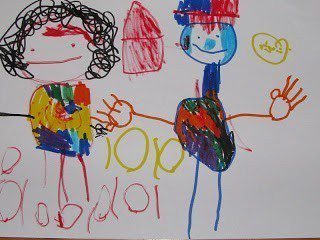

[0 1 2 3 4] 5
[[ 175.60767146   78.82968522   87.88888889]
 [ 185.5705579   202.28926395  217.18096578]
 [ 152.08324742  123.72036082  146.01237113]
 [ 198.70037453  168.11771001   29.27661851]
 [  52.04996669  134.16522318  197.23917388]]
[ 175.60767146   78.82968522   87.88888889] 7888


[[ 17  37  61]
 [179 108 116]
 [127  96 104]
 ..., 
 [ 67  21  32]
 [100  34  44]
 [195  91 102]]
[ 185.5705579   202.28926395  217.18096578] 5119


[[122 171 230]
 [142 197 251]
 [147 197 250]
 ..., 
 [208 223 242]
 [172 173 193]
 [211 209 233]]
[ 152.08324742  123.72036082  146.01237113] 4518


[[155 167 179]
 [154 152 153]
 [166 169 162]
 ..., 
 [152 102 155]
 [152  94 135]
 [111  89 110]]
[ 198.70037453  168.11771001   29.27661851] 2389


[[220 215  95]
 [227 213  55]
 [226 211  60]
 ..., 
 [195 163   0]
 [200 167   2]
 [197 180  76]]
[  52.04996669  134.16522318  197.23917388] 2586


[[ 33  67  79]
 [ 40  73  92]
 [ 67 104 133]
 ..., 
 [ 55 107 165]
 [ 39 144 212]
 [ 86  90 153]]


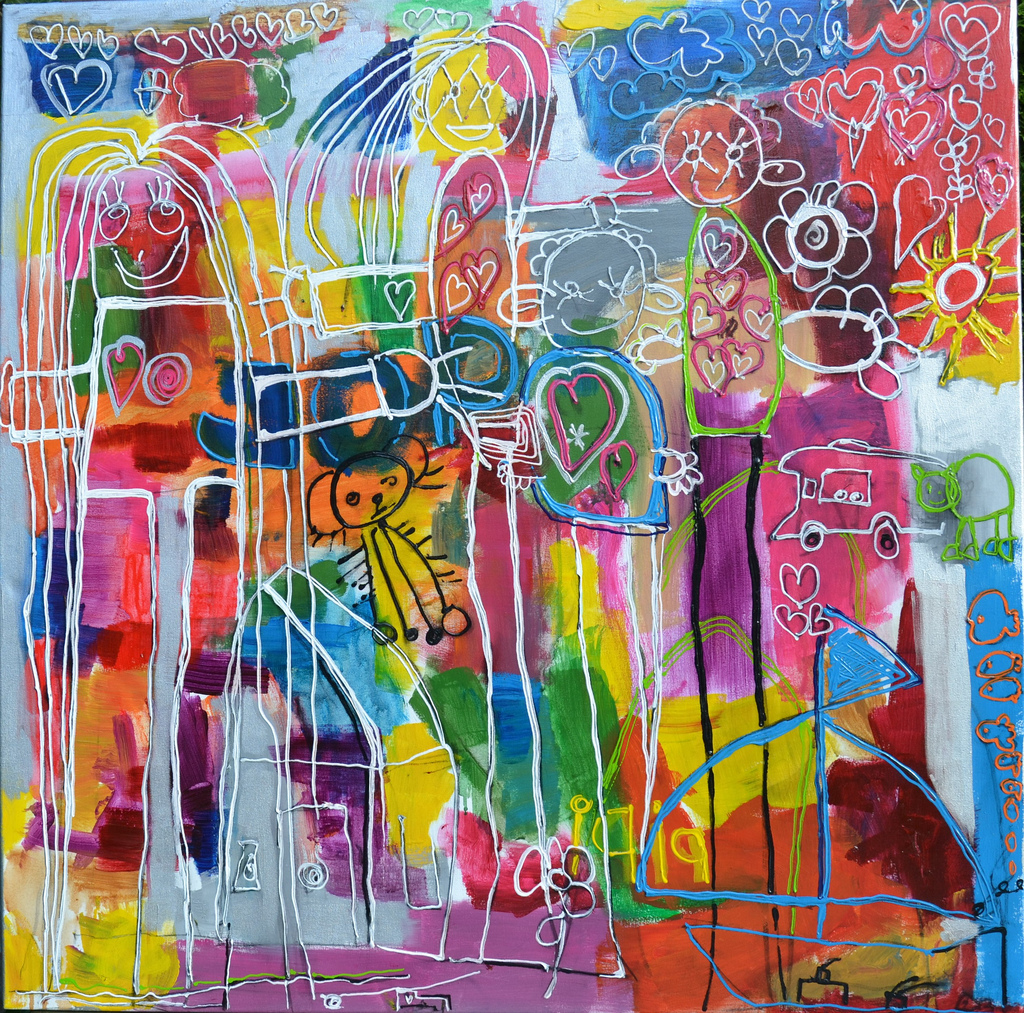

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 49
[[ 250.27535693  251.91863489  253.23029563]
 [  67.28089888   70.47191011   84.27715356]
 [ 246.8164794   149.95131086  175.08988764]
 [ 226.41700405   69.15789474   79.22267206]
 [  55.73248408  174.73248408  248.3566879 ]
 [ 245.97080292  192.10218978  203.45985401]
 [  98.85714286  185.52631579   75.41353383]
 [ 192.39175258   85.80412371   86.88659794]
 [  56.325        98.5125      199.8       ]
 [ 228.91304348  135.20289855  146.46376812]
 [ 212.03333333  120.95        125.83333333]
 [ 120.45283019  196.1509434   232.96226415]
 [ 167.5         224.26923077  249.80769231]
 [ 250.69230769  248.09615385   66.86538462]
 [ 127.92156863  198.64705882  103.76470588]
 [ 191.58695652  195.65217391  204.5       ]
 [ 187.39130435  113.91304348  111.04347826]
 [ 122.55263158  126.89473684  136.97368421]
 [ 106.88571429  111.57142857  122.94

[[237 246 243]
 [237 245 248]
 [239 247 250]
 ..., 
 [254 254 254]
 [255 253 254]
 [250 250 250]]
[ 67.28089888  70.47191011  84.27715356] 359


[[ 75  50  79]
 [ 69  63 101]
 [ 76  85  92]
 ..., 
 [ 58  52  64]
 [ 82  37  78]
 [ 82  44  95]]
[ 246.8164794   149.95131086  175.08988764] 364


[[249 154 184]
 [255 144 180]
 [255 148 173]
 ..., 
 [221 172 165]
 [241 171 173]
 [221 172 176]]
[ 226.41700405   69.15789474   79.22267206] 347


[[224  61  66]
 [224  57  74]
 [231  57  66]
 ..., 
 [224  90  97]
 [231  96 103]
 [243  72  81]]
[  55.73248408  174.73248408  248.3566879 ] 245


[[ 67 160 229]
 [ 61 181 244]
 [ 60 173 239]
 [ 69 170 240]
 [ 64 174 253]
 [ 54 177 254]
 [ 77 175 236]
 [ 87 178 233]
 [ 81 176 234]
 [ 78 170 221]
 [ 79 178 235]
 [ 77 181 242]
 [ 66 179 245]
 [ 61 164 239]
 [ 67 185 246]
 [ 68 177 236]
 [ 60 176 255]
 [ 25 149 249]
 [ 47 178 255]
 [ 70 169 236]
 [ 73 181 255]
 [ 56 178 251]
 [ 47 185 255]
 [ 69 173 236]
 [ 87 191 254]
 [ 55 173 255]
 [ 80 185 240]
 [ 55 175 251]
 [ 49 162 228]
 [ 83 168 233]
 [ 54 168 239]
 [ 27 168 255]
 [ 49 187 255]
 [ 50 158 248]
 [ 50 161 250]
 [ 36 153 246]
 [ 56 168 242]
 [ 46 163 233]
 [ 42 160 234]
 [ 51 163 249]
 [ 73 174 230]
 [ 62 174 224]
 [ 66 170 241]
 [ 58 177 255]
 [ 65 181 255]
 [ 28 159 250]
 [ 67 167 229]
 [ 54 175 244]
 [ 50 171 254]
 [ 81 181 230]
 [ 61 179 253]
 [ 67 167 242]
 [ 54 185 255]
 [ 51 161 246]
 [ 71 172 240]
 [ 36 154 241]
 [ 41 168 255]
 [ 57 179 252]
 [ 64 175 255]
 [ 44 166 252]
 [ 51 163 237]
 [ 64 179 255]
 [ 69 176 230]
 [ 60 173 243]
 [ 73 190 255]
 [ 48 163 254]
 [ 46 183 

[[244 189 208]
 [235 175 201]
 [246 219 228]
 [255 220 226]
 [235 183 196]
 [245 219 230]
 [246 176 200]
 [238 181 198]
 [255 218 229]
 [250 186 210]
 [250 185 209]
 [241 200 214]
 [239 199 208]
 [255 213 225]
 [255 215 231]
 [253 207 235]
 [255 203 225]
 [229 181 179]
 [254 183 177]
 [255 188 192]
 [255 210 213]
 [255 216 233]
 [255 203 219]
 [232 175 190]
 [255 216 211]
 [247 177 187]
 [255 179 196]
 [255 213 212]
 [236 165 199]
 [252 198 214]
 [242 185 192]
 [229 209 218]
 [241 177 201]
 [255 214 211]
 [241 179 184]
 [255 190 207]
 [255 188 191]
 [239 211 210]
 [255 214 221]
 [248 203 206]
 [255 210 218]
 [255 205 201]
 [241 172 190]
 [255 182 182]
 [255 194 207]
 [249 200 206]
 [255 214 224]
 [230 191 212]
 [253 206 216]
 [248 207 215]
 [255 208 206]
 [255 217 227]
 [255 213 232]
 [255 218 219]
 [241 189 202]
 [255 218 230]
 [235 202 211]
 [248 208 219]
 [252 178 201]
 [254 214 222]
 [235 182 198]
 [255 213 215]
 [249 201 213]
 [255 209 227]
 [255 215 234]
 [237 174 191]
 [252 194 

[[ 86 174  72]
 [ 95 180  76]
 [ 95 171  80]
 [101 196  92]
 [104 191  84]
 [105 193  80]
 [ 85 169  71]
 [ 79 165  64]
 [ 90 186  79]
 [103 203  91]
 [ 92 178  71]
 [ 86 182  59]
 [ 98 192  82]
 [ 80 168  66]
 [ 95 180  79]
 [ 88 177  71]
 [100 178  94]
 [ 79 176  63]
 [ 96 192  85]
 [ 74 170  47]
 [ 86 175  67]
 [ 94 181  77]
 [ 82 169  65]
 [ 84 169  68]
 [ 94 186  75]
 [103 191  79]
 [113 188  83]
 [ 93 195  68]
 [ 86 180  70]
 [ 86 178  69]
 [ 81 175  65]
 [ 84 172  68]
 [ 80 168  64]
 [104 186  84]
 [ 94 181  76]
 [ 94 183  75]
 [ 85 177  70]
 [ 88 180  69]
 [ 92 178  81]
 [106 194  84]
 [ 95 192  79]
 [ 97 190  84]
 [ 90 177  73]
 [ 84 171  67]
 [102 194  85]
 [ 99 188  80]
 [ 91 183  74]
 [ 77 170  66]
 [101 170  79]
 [ 91 188  75]
 [ 99 185  76]
 [ 85 176  73]
 [ 96 188  81]
 [ 90 177  72]
 [ 86 172  71]
 [ 88 173  72]
 [ 86 162  72]
 [105 181  90]
 [ 96 185  77]
 [101 191  77]
 [ 98 186  82]
 [ 86 175  67]
 [ 83 172  66]
 [ 85 173  69]
 [102 192  68]
 [ 96 180  82]
 [ 91 185 

[[219  92  99]
 [214  99 102]
 [212  91 100]
 [185  76  95]
 [205  72  93]
 [204  88 101]
 [203  73  85]
 [212 100  99]
 [207  89 101]
 [198  75  93]
 [198  90 103]
 [193  78  93]
 [201  83  99]
 [201  70  86]
 [197  86  93]
 [207  85  96]
 [214  83  97]
 [217  93 104]
 [204  78  90]
 [204  95 101]
 [207  76  84]
 [212  87  95]
 [189  78  85]
 [212  86 100]
 [202  80  91]
 [203  76  95]
 [209  92 108]
 [200  79  86]
 [213  88  82]
 [209  83  84]
 [209  82  89]
 [202  71  89]
 [209 101 101]
 [206  92 100]
 [221  98  93]
 [218  98  99]
 [181  89  90]
 [203  83  93]
 [199  65  72]
 [207  69  92]
 [199  75  77]
 [194  68  89]
 [194  72  69]
 [219  93  96]
 [212  93  99]
 [208  95  99]
 [170  74  85]
 [178  84  85]
 [185  94  91]
 [198  84  84]
 [187  83  72]
 [179  92  82]
 [181  84  75]
 [160  90  88]
 [175  71  68]
 [185  70  65]
 [191  76  71]
 [168  93  90]
 [183  80  75]
 [179  73  57]
 [178  83  81]
 [195  77  89]
 [177  80  87]
 [182  74  64]
 [171  82  78]
 [199  73  77]
 [194  78 

[[ 57 107 202]
 [ 73 111 218]
 [ 83 118 200]
 [ 82 115 196]
 [ 60  94 204]
 [ 77 114 195]
 [ 67 114 220]
 [ 59  99 213]
 [ 54  96 217]
 [ 63 102 207]
 [ 53  99 211]
 [ 55  95 193]
 [ 50  96 192]
 [ 61 102 216]
 [ 50  92 194]
 [ 69 102 181]
 [ 70 114 203]
 [ 70 119 222]
 [ 58 101 213]
 [ 60 102 210]
 [ 54  98 193]
 [ 57  84 187]
 [ 60  94 191]
 [ 46  99 175]
 [ 47  93 204]
 [ 39  81 181]
 [ 53  91 188]
 [ 45  90 193]
 [ 77 110 189]
 [ 71 113 197]
 [ 43  95 207]
 [ 45  93 175]
 [ 50  92 200]
 [ 53  97 206]
 [ 61 103 203]
 [ 66 102 178]
 [ 56  94 169]
 [ 60  99 178]
 [ 53  91 174]
 [ 61  98 186]
 [ 54  97 191]
 [ 60 104 201]
 [ 58 101 203]
 [ 57  99 207]
 [ 66 113 217]
 [ 45  97 207]
 [ 42  91 196]
 [ 48  97 202]
 [ 50  99 204]
 [ 52 102 213]
 [ 57  94 211]
 [ 55 105 216]
 [ 39 100 206]
 [ 53  97 202]
 [ 52  93 211]
 [ 52 102 213]
 [ 82 116 203]
 [ 45  97 181]
 [ 50  94 203]
 [ 57  98 186]
 [ 42  89 197]
 [ 48  95 203]
 [ 40  88 190]
 [ 48 100 202]
 [ 56 100 205]
 [ 73 110 199]
 [ 51 100 

[[245 127 161]
 [245 133 147]
 [246 132 158]
 [248 112 136]
 [235 132 153]
 [255 105 136]
 [236 120 139]
 [255  96 132]
 [251 124 135]
 [255 126 154]
 [249 117 140]
 [251 126 156]
 [240 131 150]
 [255 117 147]
 [251 127 155]
 [255 122 149]
 [251 117 141]
 [250 132 158]
 [233 127 141]
 [255 115 144]
 [238 154 152]
 [237 127 140]
 [231 139 154]
 [229 149 162]
 [248 118 130]
 [255 129 146]
 [221 132 138]
 [246 122 148]
 [244 111 138]
 [226 133 141]
 [245 119 131]
 [252 134 150]
 [248 135 155]
 [223 162 157]
 [249 111 137]
 [250 134 157]
 [249 127 142]
 [241 129 154]
 [254 136 152]
 [255 119 154]
 [244 116 131]
 [249 129 154]
 [254 117 145]
 [254 121 140]
 [249 129 154]
 [249 131 157]
 [228 137 155]
 [245 113 134]
 [240 117 146]
 [244 119 149]
 [247 115 139]
 [249 127 152]
 [219 132 141]
 [251 112 143]
 [249 122 151]
 [253 121 144]
 [242 134 158]
 [225 152 163]
 [228 145 163]
 [255 128 156]
 [246 135 152]
 [253 125 160]
 [248 130 156]
 [252 127 157]
 [224 131 142]
 [236 139 156]
 [253 129 

[[251  99 120]
 [218  93 109]
 [206 107 125]
 [238 113 117]
 [212  93 112]
 [218 109 115]
 [211 128 136]
 [222 110 122]
 [216 105 112]
 [219 116 120]
 [222 107 114]
 [212 108 117]
 [229 104 110]
 [213 127 126]
 [215 124 119]
 [238 115 120]
 [213 112 128]
 [220  98 113]
 [218 129 133]
 [211 125 124]
 [201 121 130]
 [212  94 118]
 [213 128 135]
 [213 123 133]
 [214 106 106]
 [213 122 129]
 [221 100 115]
 [212 111 117]
 [199 116 124]
 [226  98 113]
 [237 123 123]
 [203 117 126]
 [217 122 126]
 [240 117 119]
 [219 116 120]
 [210 104 108]
 [203 127 131]
 [229 101 100]
 [192 142 135]
 [219 100 122]
 [210 124 125]
 [222 116 128]
 [205 108 127]
 [251  99 120]
 [214 129 136]
 [211 108 129]
 [228  97 111]
 [206 144 133]
 [210 130 143]
 [208 146 133]
 [218 128 137]
 [229 117 133]
 [208 109 130]
 [227 114 120]
 [212  93 115]
 [215 123 124]
 [207 119 115]
 [254 108 119]
 [231  96 110]
 [242  96 119]
 [217  97 107]
 [231 105 117]
 [208 125 109]
 [220 115 109]
 [215 105 108]
 [205 132 141]
 [227 106 

[[131 193 234]
 [ 92 181 237]
 [120 196 232]
 [116 202 235]
 [129 195 255]
 [137 199 238]
 [131 212 255]
 [113 197 234]
 [108 199 254]
 [131 194 227]
 [109 203 239]
 [114 190 226]
 [133 200 242]
 [111 199 247]
 [132 211 254]
 [115 192 234]
 [113 177 225]
 [ 97 177 236]
 [101 204 239]
 [133 196 231]
 [119 189 215]
 [128 205 235]
 [ 90 185 233]
 [123 214 255]
 [124 197 229]
 [106 189 239]
 [108 196 236]
 [ 94 195 239]
 [115 195 244]
 [111 188 232]
 [ 93 167 228]
 [118 187 229]
 [ 99 191 242]
 [126 190 226]
 [135 193 231]
 [136 203 222]
 [ 98 189 234]
 [102 198 236]
 [131 212 229]
 [ 94 193 234]
 [126 198 223]
 [115 207 248]
 [105 201 223]
 [ 86 217 255]
 [104 172 235]
 [124 207 241]
 [106 187 242]
 [ 88 174 221]
 [141 200 230]
 [137 205 242]
 [128 203 242]
 [128 193 235]
 [ 89 192 251]
 [100 185 252]
 [106 188 225]
 [133 210 236]
 [129 193 221]
 [110 176 224]
 [ 98 197 255]
 [118 191 226]
 [110 193 245]
 [106 196 222]
 [ 92 184 223]
 [119 209 255]
 [112 185 226]
 [102 196 250]
 [106 189 

[[155 213 235]
 [169 223 251]
 [198 236 255]
 [200 245 242]
 [176 221 240]
 [207 226 255]
 [147 212 250]
 [169 219 230]
 [155 212 241]
 [159 224 255]
 [177 237 255]
 [202 224 248]
 [157 219 244]
 [149 223 250]
 [163 228 255]
 [151 212 240]
 [174 231 255]
 [197 250 255]
 [193 231 232]
 [162 218 253]
 [166 230 255]
 [197 250 255]
 [136 221 255]
 [203 255 255]
 [156 228 252]
 [193 235 255]
 [173 224 253]
 [195 238 255]
 [160 216 239]
 [202 250 255]
 [158 225 242]
 [178 234 255]
 [161 215 241]
 [157 223 255]
 [182 233 255]
 [172 237 255]
 [182 233 255]
 [159 222 255]
 [177 214 255]
 [145 232 255]
 [156 223 252]
 [205 234 250]
 [184 234 255]
 [197 239 255]
 [186 251 255]
 [182 255 255]
 [185 230 255]
 [161 222 251]
 [187 234 255]
 [168 212 249]
 [177 230 244]
 [146 226 255]
 [195 236 254]
 [166 237 255]
 [175 229 241]
 [169 216 242]
 [152 221 255]
 [188 255 255]
 [176 240 255]
 [159 234 255]
 [195 231 253]
 [193 245 255]
 [171 223 245]
 [137 222 253]
 [194 238 255]
 [201 248 255]
 [143 214 

[[247 249  78]
 [245 249  68]
 [255 255  74]
 [249 255  51]
 [252 252  68]
 [250 249  63]
 [249 255  76]
 [249 248  62]
 [251 246  84]
 [245 252  74]
 [254 242  58]
 [249 249  73]
 [253 254  74]
 [250 250  66]
 [252 252  58]
 [248 248  66]
 [253 251  70]
 [253 230  64]
 [253 252  66]
 [252 254  57]
 [247 246  78]
 [238 233  81]
 [249 245  58]
 [255 246  79]
 [254 252  55]
 [249 251  54]
 [254 244  68]
 [253 253  77]
 [255 251  70]
 [249 246  83]
 [255 255  40]
 [244 249  33]
 [255 236  53]
 [240 250  65]
 [255 241  56]
 [245 239  79]
 [252 248  53]
 [245 255  58]
 [250 250  66]
 [247 255  70]
 [255 253  60]
 [247 253  67]
 [255 248  79]
 [252 245  68]
 [255 252  64]
 [255 255  77]
 [251 250  62]
 [247 241  55]
 [250 236  78]
 [254 245  62]
 [251 235  62]
 [255 243  65]
 [248 248  52]
 [250 255  70]
 [249 245  23]]
[ 127.92156863  198.64705882  103.76470588] 69


[[108 196  96]
 [130 191 122]
 [111 202  97]
 [129 194 102]
 [111 203  94]
 [112 201  95]
 [128 200 124]
 [137 207 118]
 [119 208 100]
 [116 189  97]
 [134 200 100]
 [126 215 109]
 [116 189 116]
 [135 223 119]
 [112 195  91]
 [144 217 102]
 [125 206 101]
 [129 198 105]
 [142 197 114]
 [122 198 108]
 [146 197 118]
 [118 195  91]
 [124 197 105]
 [144 199 115]
 [127 195 108]
 [112 185  95]
 [118 204  81]
 [121 181 109]
 [130 207 105]
 [140 202 119]
 [136 212 104]
 [141 200 118]
 [116 204  84]
 [137 201 105]
 [127 194 101]
 [133 217  96]
 [129 221  96]
 [133 210  98]
 [117 181  94]
 [137 196 112]
 [138 198 108]
 [138 198 102]
 [120 208  85]
 [128 192  95]
 [132 212 101]
 [133 198 104]
 [129 197  98]
 [125 197  98]
 [119 210  83]
 [132 197 103]
 [124 199  98]
 [126 205  98]
 [126 191  89]
 [117 205  85]
 [145 204 120]
 [118 209  88]
 [151 189 114]
 [128 176 100]
 [131 188 107]
 [120 187 110]
 [123 194 100]
 [115 203  83]
 [138 204 116]
 [121 186  92]
 [123 195  96]
 [122 200  91]
 [136 194 

[[192 200 203]
 [215 223 226]
 [210 218 221]
 [218 223 227]
 [215 205 206]
 [183 196 213]
 [172 194 215]
 [194 198 207]
 [197 198 203]
 [212 189 199]
 [214 217 222]
 [197 186 200]
 [196 200 209]
 [173 180 188]
 [213 217 226]
 [178 182 191]
 [215 218 223]
 [179 185 201]
 [192 205 221]
 [190 188 191]
 [209 212 219]
 [200 197 206]
 [189 193 202]
 [182 186 198]
 [198 214 227]
 [179 188 203]
 [195 197 210]
 [181 182 186]
 [212 211 225]
 [209 217 230]
 [184 185 190]
 [186 184 195]
 [187 185 198]
 [191 200 209]
 [213 206 213]
 [201 200 206]
 [193 193 203]
 [181 184 193]
 [202 206 217]
 [189 199 209]
 [202 209 217]
 [212 220 223]
 [183 195 209]
 [194 197 202]
 [191 191 199]
 [184 192 213]
 [173 182 213]
 [198 199 203]
 [202 205 212]
 [202 207 213]
 [218 190 178]
 [195 201 213]
 [194 202 215]
 [196 203 195]
 [217 221 233]
 [188 186 189]
 [209 216 224]
 [177 182 188]
 [219 220 225]
 [211 191 184]
 [205 211 209]
 [198 205 221]
 [182 186 197]
 [217 218 220]
 [207 212 218]
 [205 208 217]
 [195 200 

[[207 102 109]
 [197 102 122]
 [193 110 130]
 [170  88 110]
 [199 110 116]
 [202 102 112]
 [207 102 107]
 [175 106  99]
 [198 117 116]
 [173 110 101]
 [173 115 113]
 [180 111 106]
 [181 126 129]
 [177 127 128]
 [197 129 116]
 [179 115 105]
 [200 120 111]
 [182 105 113]
 [187 127 126]
 [168 113 106]
 [178 117 116]
 [171 109  98]
 [182 121 118]
 [185 100 105]
 [193 118 112]
 [180 121 115]
 [196 126 118]
 [187 106 102]
 [163 118 121]
 [177 106 102]
 [194 116 116]
 [176  97 102]
 [182 116 100]
 [190 129 124]
 [172 113 105]
 [177 113 113]
 [206 115  96]
 [193 113  90]
 [199 122  92]
 [206 108  99]
 [209 100 106]
 [207 103 100]
 [186 102 100]
 [208 111 102]
 [188 109 114]
 [185 111 112]
 [169 113  96]
 [180 110 100]
 [204 105 100]
 [208 104 105]
 [193 128 122]
 [200 116 105]
 [205 104 108]
 [173 124 117]
 [178 114 112]
 [183 131 120]
 [191 106 103]
 [193 113 102]
 [193 111  97]
 [176 117 111]
 [187 102  97]]
[ 122.55263158  126.89473684  136.97368421] 35


[[123 127 139]
 [128 131 146]
 [143 142 148]
 [121 120 128]
 [121 131 133]
 [131 136 142]
 [132 124 135]
 [121 128 138]
 [129 133 142]
 [126 134 145]
 [130 134 137]
 [129 129 141]
 [127 130 139]
 [122 128 140]
 [124 136 150]
 [115 122 132]
 [134 135 137]
 [120 126 138]
 [120 125 129]
 [153 130 136]
 [142 139 148]
 [115 120 140]
 [142 143 145]
 [134 137 144]
 [117 124 134]
 [111 120 135]
 [126 131 137]
 [130 136 152]
 [116 123 131]
 [119 123 132]
 [123 130 140]
 [132 135 144]
 [123 134 140]
 [131 134 141]
 [129 132 139]]
[ 106.88571429  111.57142857  122.94285714] 53


[[ 93 108 129]
 [ 94 100 116]
 [ 94  94 104]
 [ 88 104 117]
 [ 94  98 101]
 [102  99 108]
 [ 91  97 111]
 [ 93  97 109]
 [100 104 116]
 [ 94  94 106]
 [115 118 127]
 [ 88  86 110]
 [115 114 128]
 [109 109 121]
 [ 91  94 101]
 [106 113 123]
 [ 99 105 119]
 [ 89  92 109]
 [100 104 116]
 [ 90  94 103]
 [ 93  95 107]
 [106 110 122]
 [102 106 117]
 [104 113 118]
 [110 117 135]
 [ 94  96 109]
 [103 101 114]
 [ 95  97 109]
 [ 90  93 102]
 [103 107 116]
 [ 93  99 113]
 [ 96 104 107]
 [102 109 125]
 [ 94  94 102]
 [ 99 103 112]
 [ 87  93 107]
 [106 105 113]
 [ 92  98 112]
 [ 93  94  99]
 [111 117 133]
 [ 88  91 110]
 [120 117 126]
 [ 93  97 108]
 [113 115 127]
 [ 87  94 110]
 [ 88  92 103]
 [ 86  94 105]
 [ 93  96 115]
 [ 94 103 110]
 [103 107 118]
 [ 90  92 105]
 [114 116 129]
 [ 93  99 111]]
[ 155.75757576  159.03030303  167.18181818] 40


[[158 165 173]
 [150 153 162]
 [156 162 174]
 [144 146 159]
 [170 172 184]
 [144 150 166]
 [166 172 186]
 [146 152 164]
 [153 150 161]
 [168 173 176]
 [173 172 177]
 [155 164 169]
 [164 170 182]
 [158 165 171]
 [164 165 170]
 [151 154 173]
 [154 161 171]
 [145 150 156]
 [157 161 173]
 [137 143 155]
 [160 161 165]
 [161 163 175]
 [138 145 155]
 [161 164 171]
 [173 152 161]
 [148 148 156]
 [158 159 164]
 [162 166 167]
 [148 152 155]
 [152 155 162]
 [169 173 172]
 [143 152 167]
 [150 155 174]
 [156 157 159]
 [159 163 172]
 [151 155 158]
 [142 142 154]
 [157 162 166]
 [165 170 173]
 [142 146 155]]
[ 252.21428571  251.89285714  200.64285714] 73


[[246 228 218]
 [255 223 226]
 [255 225 224]
 [255 229 227]
 [255 235 221]
 [248 245 226]
 [255 228 226]
 [220 255 214]
 [240 255 212]
 [229 255 217]
 [230 255 223]
 [255 234 225]
 [255 226 226]
 [255 224 225]
 [255 223 226]
 [247 226 223]
 [253 225 222]
 [255 223 220]
 [225 251 222]
 [222 255 210]
 [255 224 225]
 [250 239 221]
 [227 249 213]
 [236 255 221]
 [223 250 217]
 [233 253 225]
 [238 236 224]
 [242 225 217]
 [255 229 220]
 [255 249 224]
 [225 255 212]
 [230 253 224]
 [248 255 223]
 [255 225 214]
 [255 255 220]
 [255 252 183]
 [253 251 177]
 [255 254 219]
 [255 254 208]
 [255 255 199]
 [255 248 176]
 [255 250 195]
 [252 248 200]
 [252 252 182]
 [255 255 225]
 [245 243 195]
 [251 255 219]
 [254 254 194]
 [252 247 181]
 [254 254 200]
 [242 246 172]
 [249 251 201]
 [252 244 179]
 [255 250 211]
 [255 252 219]
 [255 252 224]
 [250 255 208]
 [255 254 225]
 [254 250 189]
 [244 243 189]
 [255 255 215]
 [244 248 225]
 [254 253 173]
 [253 255 215]
 [252 255 224]
 [248 250 184]
 [253 249 

[[250 245 119]
 [253 250 137]
 [246 245 129]
 [250 249 122]
 [251 243 162]
 [255 252 135]
 [255 249 161]
 [249 248 139]
 [249 249 119]
 [248 245 148]
 [254 249 132]
 [248 255 152]
 [254 249 119]
 [255 250 148]
 [254 249 145]
 [251 255 142]
 [255 253 131]
 [255 247 148]
 [240 249 132]
 [247 248 146]
 [252 250 127]
 [252 242 127]
 [254 251 136]
 [246 246 126]
 [251 244 127]]
[ 174.85  218.55  158.85] 21


[[178 242 156]
 [162 244 142]
 [175 214 161]
 [184 213 169]
 [161 216 159]
 [181 224 170]
 [176 203 162]
 [171 228 159]
 [183 213 149]
 [169 208 155]
 [172 229 150]
 [187 225 168]
 [178 223 166]
 [167 225 149]
 [167 223 158]
 [181 217 147]
 [174 214 162]
 [189 227 152]
 [176 215 171]
 [171 218 164]
 [173 221 163]]
[ 248.75  247.4   101.35] 14


[[249 246 105]
 [248 242  84]
 [249 242 102]
 [239 247 109]
 [250 249  97]
 [238 241  88]
 [253 247  91]
 [255 250  97]
 [244 255 101]
 [255 243 102]
 [241 255  88]
 [241 247  99]
 [255 250 114]
 [255 250 104]]
[ 160.36842105  191.          237.36842105] 19


[[148 199 230]
 [145 205 242]
 [157 210 241]
 [164 186 233]
 [143 187 234]
 [160 183 227]
 [160 187 234]
 [155 189 224]
 [168 184 243]
 [158 200 238]
 [164 195 252]
 [173 196 228]
 [158 185 254]
 [157 189 236]
 [172 196 244]
 [151 183 230]
 [158 183 239]
 [169 201 248]
 [177 200 244]]
[ 156.8125  208.625   141.4375] 16


[[147 199 151]
 [147 233 136]
 [155 218 137]
 [145 206 128]
 [150 206 117]
 [158 200 152]
 [150 199 118]
 [152 214 137]
 [169 204 140]
 [160 206 133]
 [157 205 131]
 [154 202 150]
 [153 201 139]
 [155 209 133]
 [145 210 126]
 [162 215 143]]
[ 196.1875  240.375   186.3125] 24


[[220 226 216]
 [191 250 194]
 [194 242 190]
 [185 255 169]
 [196 240 177]
 [207 255 197]
 [216 250 213]
 [186 238 189]
 [198 249 183]
 [194 240 201]
 [199 236 193]
 [219 246 201]
 [214 249 209]
 [183 231 181]
 [202 235 178]
 [199 230 173]
 [198 244 180]
 [199 237 178]
 [209 234 212]
 [199 245 181]
 [206 240 189]
 [188 234 197]
 [220 249 201]
 [218 254 210]]
[ 112.3  140.5  202.5] 28


[[ 98 161 204]
 [116 146 210]
 [ 92 129 218]
 [108 167 199]
 [ 90 126 202]
 [ 92 126 189]
 [119 141 201]
 [ 97 132 196]
 [115 137 212]
 [126 152 189]
 [111 145 206]
 [127 155 205]
 [115 133 181]
 [101 136 190]
 [ 88 129 219]
 [108 134 195]
 [ 99 127 192]
 [108 132 176]
 [ 91 117 194]
 [117 147 217]
 [101 126 183]
 [ 84 120 214]
 [ 89 123 195]
 [ 86 132 230]
 [ 85 128 223]
 [ 83 129 240]
 [112 132 193]
 [ 90 121 227]]
[ 142.33333333  169.66666667  226.33333333] 7


[[155 176 231]
 [141 168 235]
 [136 166 220]
 [131 156 222]
 [147 159 233]
 [140 167 220]
 [137 165 212]]
[ 131.14285714   88.42857143   60.71428571] 35


[[160  59  63]
 [164  63  45]
 [158  78  77]
 [163  70  63]
 [149  81  80]
 [166  68  55]
 [152  74  62]
 [147  74  57]
 [148  66  52]
 [150  74  58]
 [165  67  58]
 [160  69  51]
 [154  77  61]
 [154  78  64]
 [169  57  53]
 [155  71  47]
 [156  73  57]
 [148  73  67]
 [161  63  60]
 [155  70  67]
 [161  72  56]
 [160  61  55]
 [167  64  55]
 [158  61  54]
 [163  69  61]
 [147  58  60]
 [140  79  58]
 [127  97  73]
 [160  48  64]
 [172  68  41]
 [148  78  53]
 [119  92  62]
 [132  82  55]
 [146  92  64]
 [133 100  65]]
[ 87.          90.57142857  42.85714286] 10


[[ 74  99  42]
 [ 79  90  34]
 [ 96  99  54]
 [ 82 119  49]
 [ 89  84  44]
 [ 98  81  37]
 [ 89  93  60]
 [ 60  93  40]
 [ 97 114  43]
 [ 84  88  29]]
[ 111.2  141.4   71.2] 5


[[107 142  74]
 [102 148  75]
 [116 135  54]
 [116 146  84]
 [115 136  69]]
[ 127.25   81.75  100.25] 9


[[151  95  98]
 [158  92  93]
 [120  81 108]
 [133  80  98]
 [117  83  99]
 [158  89 107]
 [157  82  86]
 [115  63  86]
 [139  83  96]]
[  66.66666667  105.33333333   71.        ] 4


[[ 52  85  64]
 [ 64 109  66]
 [ 72 105  84]
 [ 64 102  63]]
[ 182.33333333  123.66666667  174.33333333] 7


[[183 116 183]
 [180 130 142]
 [185 123 172]
 [198 154 169]
 [179 132 168]
 [198 160 173]
 [197 140 155]]
[ 114.33333333   67.33333333   55.        ] 8


[[149  34  49]
 [147  53  45]
 [135  62  55]
 [142  59  51]
 [142  59  51]
 [121  77  48]
 [107  58  54]
 [115  67  63]]
[ 147.   159.5  113.5] 3


[[145 157 111]
 [161 140 113]
 [149 162 116]]
[ 102.    44.5   34.5] 6


[[ 63  44  50]
 [130  54  30]
 [100  49  28]
 [132  49  35]
 [ 60  34  45]
 [104  40  41]]
[ 128.  157.  255.] 2


[[128 157 255]
 [114 148 237]]
[  71.  151.   92.] 8


[[ 80 162  64]
 [ 84 163  72]
 [ 76 160  64]
 [ 82 165  73]
 [ 76 164  62]
 [ 80 161  68]
 [ 81 162  67]
 [ 71 151  92]]
[ 143.  101.  141.] 3


[[143 101 141]
 [148 102 115]
 [167 120 140]]
[  70.  133.   76.] 13


[[ 74 161  54]
 [ 75 163  59]
 [ 73 155  57]
 [ 72 154  56]
 [ 74 158  62]
 [ 71 152  59]
 [ 75 159  61]
 [ 74 163  57]
 [ 73 159  62]
 [ 72 155  63]
 [ 80 156  66]
 [ 76 160  49]
 [ 70 133  76]]
[  46.  126.   39.] 1


[[ 46 126  39]]
[  91.  122.  153.] 11


[[ 79 119 181]
 [ 92 125 176]
 [103 124 177]
 [ 75  98 165]
 [ 85 120 188]
 [ 79 106 177]
 [ 91 122 153]
 [ 88 117 175]
 [107 122 177]
 [ 80 107 178]
 [ 88 120 177]]
[  73.  115.  137.] 1


[[ 73 115 137]]
[ 137.  187.  198.] 2


[[137 187 198]
 [162 181 198]]
[  44.  145.  187.] 3


[[ 39 137 228]
 [ 27 137 232]
 [ 44 145 187]]
[  52.   64.  140.] 7


[[ 55  69 166]
 [ 46  75 167]
 [ 52  64 140]
 [ 30  60 174]
 [ 36  64 174]
 [ 36  74 175]
 [ 42  73 164]]
[  75.   67.  140.] 4


[[ 68  73 175]
 [ 75  67 140]
 [ 80  80 170]
 [ 69  82 117]]


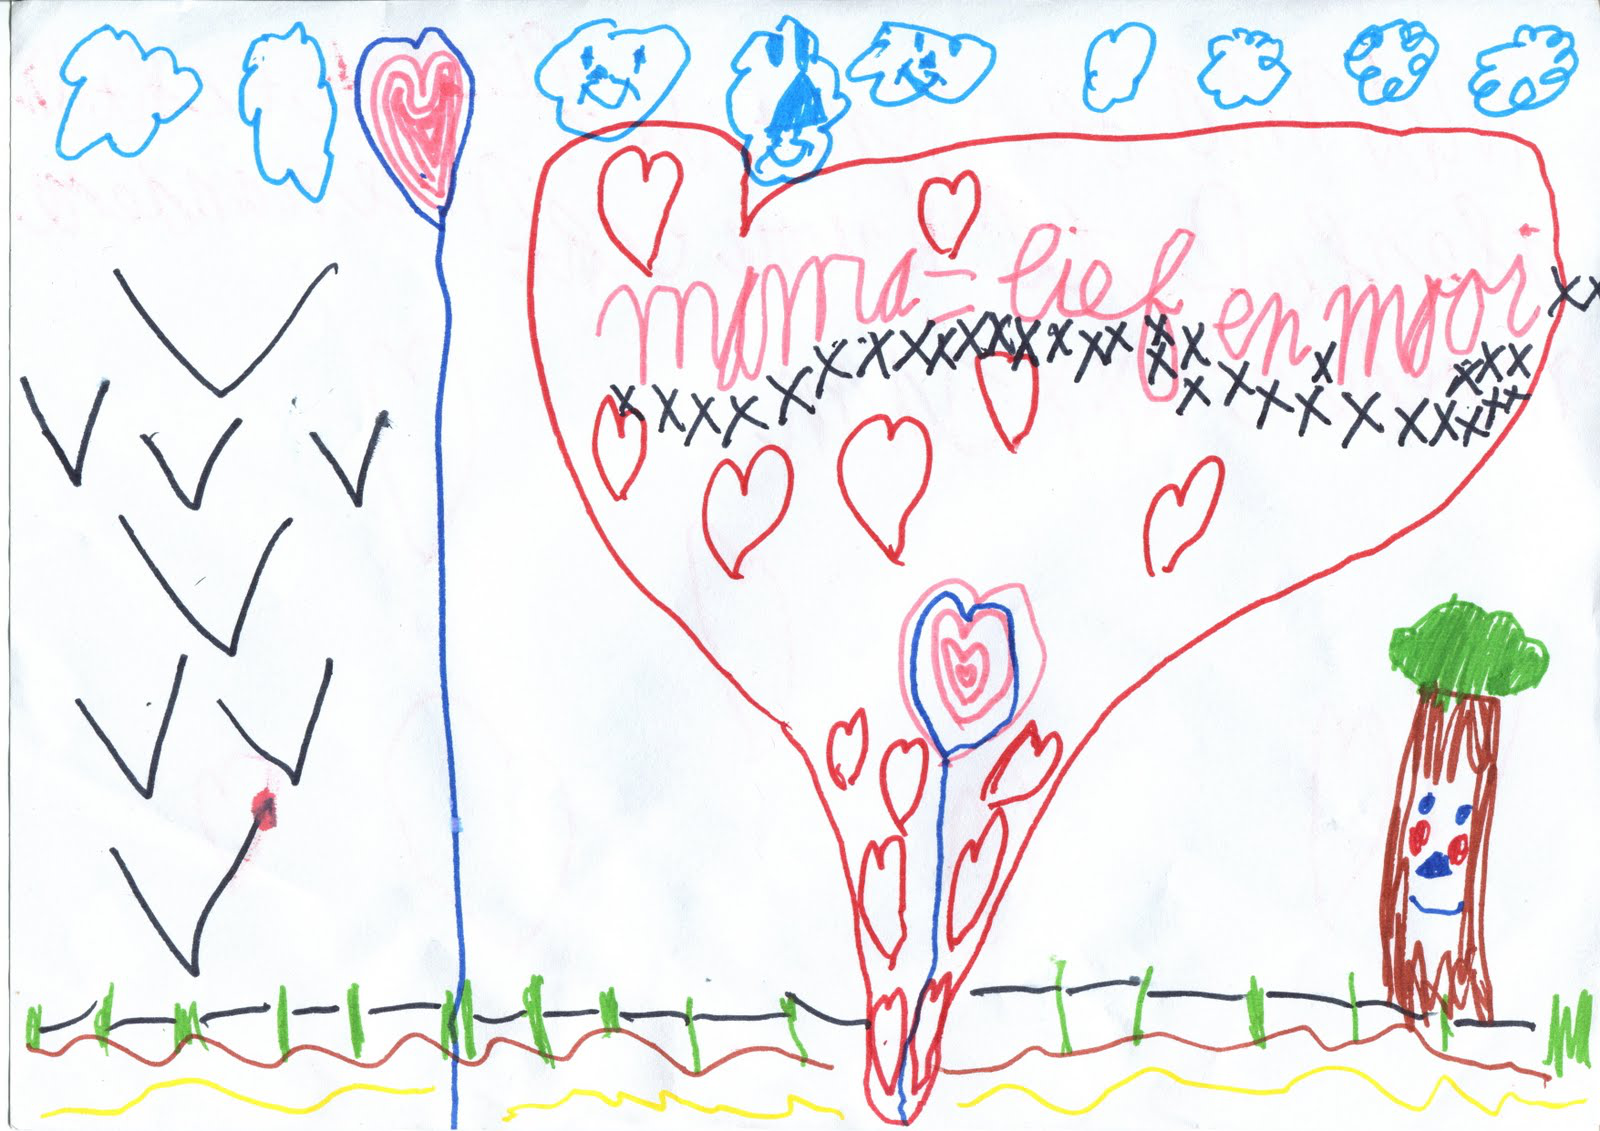

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] 14
[[  58.79114976   28.49520399   94.56465021]
 [  48.57316672   26.76520881   31.7533706 ]
 [ 209.7150838    33.5735568    35.99068901]
 [ 250.88590604  210.35346756   55.05145414]
 [ 122.16019417   94.36893204   41.27669903]
 [ 147.94578313  112.6626506    39.46987952]
 [ 254.80666667  215.50666667    6.21333333]
 [ 174.1         136.42        130.48      ]
 [ 198.59183673  171.28571429  155.71428571]
 [ 220.72972973  197.91891892  189.13513514]
 [ 243.05405405  232.97297297  222.91891892]
 [ 223.14285714  106.71428571  108.14285714]
 [ 222.          204.          243.        ]
 [ 187.          176.          208.        ]]
[ 58.79114976  28.49520399  94.56465021] 11469


[[99 62 80]
 [90 64 77]
 [92 66 79]
 ..., 
 [87 55 58]
 [99 41 56]
 [90 44 57]]
[ 48.57316672  26.76520881  31.7533706 ] 8188


[[46 23  0]
 [43  5  0]
 [34  5  0]
 ..., 
 [23  7  0]
 [23  7  0]
 [32  2  0]]
[ 209.7150838    33.5735568    35.99068901] 865


[[189  71  69]
 [196  64  60]
 [203  66  60]
 ..., 
 [162  53  56]
 [173  47  61]
 [175  64  71]]
[ 250.88590604  210.35346756   55.05145414] 447


[[235 205  55]
 [255 216  55]
 [249 213  57]
 ..., 
 [247 211  52]
 [247 211  52]
 [234 204  74]]
[ 122.16019417   94.36893204   41.27669903] 895


[[117  89 104]
 [121  93 108]
 [120  92 107]
 ..., 
 [124  63  34]
 [144  83  54]
 [143  82  53]]
[ 147.94578313  112.6626506    39.46987952] 206


[[152 107  22]
 [149 131  67]
 [162 123  46]
 [176 139  48]
 [141 105  55]
 [153 126  23]
 [146 114  73]
 [131 117  28]
 [150 119  52]
 [163 126  22]
 [152 105  23]
 [136 116  27]
 [166 126  57]
 [155 116  51]
 [146 112  23]
 [146 112  67]
 [153 117  65]
 [177 125  50]
 [163 113  60]
 [155 113  13]
 [165 127  54]
 [159 125  35]
 [148 116  43]
 [141 102  25]
 [171 120  37]
 [135 104  22]
 [152 122  62]
 [140 105  47]
 [149  98  35]
 [160 116  17]
 [144 111  16]
 [140 108  25]
 [148 105  71]
 [143 104  71]
 [171 129  71]
 [151 116   0]
 [153 131  22]
 [151 121  49]
 [158 118  31]
 [147 116  49]
 [148 122  37]
 [173 124  48]
 [154 111  58]
 [164 131  24]
 [145 106  41]
 [182 119  14]
 [172 129  16]
 [157 111  59]
 [139 113  36]
 [139 100  33]
 [137 113  15]
 [168 121  39]
 [157 116  11]
 [161 120  12]
 [149 132  40]
 [132 109  29]
 [167 121  43]
 [166 130  16]
 [153 112  22]
 [169 124  41]
 [180 131  38]
 [159 112  56]
 [130 118  36]
 [143 100  31]
 [144 107  27]
 [165 138  25]
 [142 104 

[[255 220  10]
 [255 209  22]
 [255 215  15]
 [255 219   0]
 [255 217   0]
 [255 214  14]
 [255 217   4]
 [255 219   6]
 [255 218   5]
 [255 216   3]
 [255 217   4]
 [255 214   1]
 [255 215   2]
 [255 214   1]
 [255 215   2]
 [255 216   3]
 [255 218   5]
 [255 215   2]
 [255 212   0]
 [255 213   0]
 [255 219   6]
 [255 219   6]
 [255 218   5]
 [255 215   2]
 [255 215   2]
 [255 215   2]
 [255 215   2]
 [255 215   2]
 [255 214   1]
 [255 214   1]
 [255 215   2]
 [255 214   1]
 [255 215   2]
 [255 214   3]
 [255 214   3]
 [255 214   3]
 [255 214   3]
 [255 216   5]
 [255 218   7]
 [255 217   6]
 [255 215   5]
 [255 213   3]
 [255 212   2]
 [255 214   4]
 [255 216   6]
 [255 216   6]
 [255 216   6]
 [255 215   3]
 [255 216   4]
 [255 216   4]
 [255 215   3]
 [255 216   4]
 [255 216   4]
 [255 216   4]
 [255 215   3]
 [255 214   2]
 [255 213   1]
 [255 213   1]
 [255 215   3]
 [255 216   4]
 [255 216   4]
 [255 215   4]
 [255 215   4]
 [255 215   4]
 [255 215   4]
 [255 214   3]
 [255 214 

[[183 145 142]
 [177 151 136]
 [178 138 139]
 [164 123 127]
 [162 120 124]
 [153 110 117]
 [147 114 125]
 [144 111 122]
 [137 105 116]
 [144 112 125]
 [141 111 123]
 [129 101 116]
 [123  87 115]
 [128  93 117]
 [119  92 125]
 [121  94 127]
 [162 119 138]
 [143 101 111]
 [127  70 121]
 [124  71 127]
 [154 123 131]
 [146 102 137]
 [128  81 125]
 [129 105 118]
 [136  99 143]
 [124  79 134]
 [129  84 139]
 [162 119 173]
 [131  88 142]
 [144 110  98]
 [159 108 141]
 [134  83 124]
 [135 109 112]
 [142  95 137]
 [123  75 123]
 [127  84 129]
 [131  87 136]
 [114  76 151]
 [115  78 147]
 [116  78 151]
 [121  80 138]
 [120  95 137]
 [119  76 132]
 [117  75 139]
 [136  94 144]
 [119  74 141]
 [138  91 143]
 [156 118 143]
 [121  79 145]
 [119  72 140]
 [111  87 121]
 [131  87 138]
 [123  78 133]
 [120  76 125]
 [120  77 130]
 [110  78 154]
 [118 103 146]
 [144 118 153]
 [132  93 124]
 [147  89 103]
 [155 127  90]
 [124  86 125]
 [131 110 169]
 [137 103 163]
 [123  72 149]
 [117  89 140]
 [114  84 

[[183 160 142]
 [183 143 167]
 [189 149 150]
 [195 140 180]
 [213 165 116]
 [209 177 154]
 [205 172 165]
 [195 162 155]
 [207 184 166]
 [205 182 164]
 [207 184 170]
 [205 186 171]
 [182 165 149]
 [199 186 169]
 [193 180 163]
 [184 149 153]
 [190 159 164]
 [202 172 174]
 [195 165 165]
 [209 179 177]
 [206 177 173]
 [205 176 134]
 [207 177 139]
 [211 181 147]
 [218 188 152]
 [220 191 151]
 [217 188 146]
 [218 189 147]
 [197 161 139]
 [193 162 142]
 [199 170 152]
 [189 160 142]
 [203 175 154]
 [200 172 150]
 [205 177 153]
 [198 169 155]
 [187 159 145]
 [186 160 145]
 [183 156 149]
 [182 154 151]
 [199 172 161]
 [205 178 167]
 [194 167 156]
 [202 175 164]
 [205 178 167]
 [202 182 171]]
[ 220.72972973  197.91891892  189.13513514] 27


[[229 196 187]
 [225 196 188]
 [221 198 182]
 [224 201 185]
 [211 189 175]
 [222 192 194]
 [217 187 189]
 [217 187 189]
 [219 189 191]
 [219 189 191]
 [222 199 193]
 [220 197 191]
 [220 197 191]
 [229 205 201]
 [232 208 204]
 [234 210 206]
 [227 203 199]
 [228 198 164]
 [208 188 177]
 [214 194 183]
 [216 196 185]
 [225 205 194]
 [217 197 186]
 [226 208 196]
 [226 208 196]
 [230 216 203]
 [225 211 198]]
[ 243.05405405  232.97297297  222.91891892] 35


[[248 227 222]
 [234 217 210]
 [232 217 210]
 [233 217 204]
 [233 218 211]
 [232 219 211]
 [229 216 208]
 [232 222 213]
 [239 229 220]
 [245 235 226]
 [250 240 231]
 [240 230 221]
 [250 240 231]
 [254 244 235]
 [251 242 233]
 [247 238 229]
 [255 251 240]
 [252 244 231]
 [245 238 222]
 [244 238 226]
 [251 245 233]
 [250 244 232]
 [248 242 230]
 [249 243 231]
 [252 246 232]
 [250 244 230]
 [250 244 232]
 [249 243 231]
 [246 239 229]
 [246 238 227]
 [237 229 218]
 [242 236 224]
 [236 232 220]
 [235 233 220]
 [243 214 216]]
[ 223.14285714  106.71428571  108.14285714] 36


[[202  77  75]
 [219  72  90]
 [203  66  86]
 [185  63  86]
 [179  79  79]
 [184  74  85]
 [198  71  88]
 [178  67  83]
 [186  73  91]
 [185  75  76]
 [209 120 104]
 [231 114 132]
 [176  80  91]
 [178  79  99]
 [169  81  93]
 [175  69  91]
 [180  70  83]
 [178  64  90]
 [221 131 133]
 [181  76  91]
 [191  75  88]
 [188  79  84]
 [205  74  79]
 [186  72  80]
 [215  75  78]
 [236  88 104]
 [166  70  97]
 [211  90 107]
 [205  79  90]
 [235 117 152]
 [182  65  92]
 [175  69  91]
 [201  80  97]
 [238  97  90]
 [226 109 102]
 [211 129 118]]
[ 222.  204.  243.] 2


[[227 209 249]
 [217 199 237]]
[ 187.  176.  208.] 2


[[176 131 186]
 [187 176 208]]


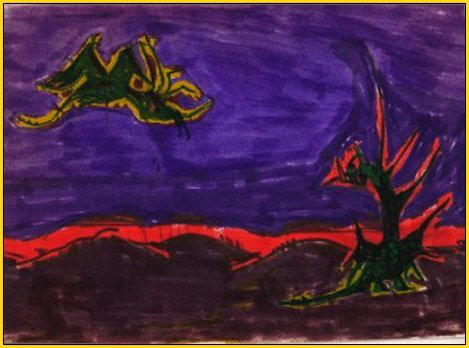

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] 18
[[ 241.82246377  244.00106564  247.88629582]
 [ 245.37315271  218.07783251   54.07315271]
 [  55.88677249  144.4010582   213.84338624]
 [ 108.79548157  178.20808561  232.26753864]
 [ 244.28822733  176.51962111   77.05277402]
 [ 241.97222222  225.11111111  153.02592593]
 [  87.62903226   78.83870968   69.20967742]
 [ 158.83333333  144.16666667   67.5       ]
 [ 135.6         124.2          81.6       ]
 [ 130.          113.4          34.4       ]
 [ 185.5         161.           17.5       ]
 [  81.          122.          108.        ]
 [  34.          144.          115.        ]
 [ 154.          189.          133.        ]
 [ 132.          178.          150.        ]
 [  58.          148.           94.        ]
 [  99.          176.           96.        ]
 [ 167.          158.          143.        ]]
[ 241.82246377  244.00106564  247.88629582] 11100


[[242 243 248]
 [242 243 248]
 [243 244 249]
 ..., 
 [246 244 247]
 [247 247 249]
 [240 241 245]]
[ 245.37315271  218.07783251   54.07315271] 4886


[[245 223  77]
 [235 231  97]
 [244 230  95]
 ..., 
 [241 235  99]
 [236 228 101]
 [236 244  81]]
[  55.88677249  144.4010582   213.84338624] 1662


[[ 51 124 201]
 [ 45 142 219]
 [ 31 145 231]
 ..., 
 [ 79 156 202]
 [ 84 157 198]
 [ 83 161 210]]
[ 108.79548157  178.20808561  232.26753864] 2396


[[140 204 240]
 [112 188 240]
 [144 202 240]
 ..., 
 [129 178 219]
 [ 99 165 215]
 [119 186 228]]
[ 244.28822733  176.51962111   77.05277402] 990


[[253 181  81]
 [229 181 109]
 [229 168  85]
 ..., 
 [246 180  93]
 [225 166 106]
 [248 179 104]]
[ 241.97222222  225.11111111  153.02592593] 1283


[[241 240 196]
 [240 231 154]
 [220 190 154]
 ..., 
 [232 216 183]
 [255 218 173]
 [232 222 197]]
[ 87.62903226  78.83870968  69.20967742] 81


[[ 79  61  57]
 [ 81  79  84]
 [ 69  63  77]
 [ 83  72  78]
 [ 87  78  79]
 [ 79  71  68]
 [ 72  73  68]
 [ 73  73  49]
 [ 89  73  58]
 [ 80  73  67]
 [ 74  69  40]
 [ 68  69  53]
 [ 73  69  34]
 [ 81  71  72]
 [ 84  80  81]
 [ 84  72  46]
 [ 85  81  20]
 [ 91  76  73]
 [ 72  69  76]
 [ 92  81  95]
 [ 78  79  39]
 [ 99  84  61]
 [ 72  59  42]
 [ 80  82  77]
 [ 81  70  40]
 [ 99  81  41]
 [ 87  73  62]
 [ 88  76  80]
 [ 81  73  52]
 [ 77  53  15]
 [ 95  83  33]
 [100  82  78]
 [ 94  84  74]
 [ 95  84  80]
 [ 93  92  72]
 [ 81  82  48]
 [ 79  80  74]
 [ 98  83  88]
 [ 79  63  37]
 [ 94  80  67]
 [ 92  87  57]
 [ 70  67  24]
 [ 99  94  72]
 [ 97  86  68]
 [ 95  87  68]
 [ 88  77  83]
 [ 76  59  52]
 [ 97  82  25]
 [ 99  64  45]
 [ 94  86  49]
 [ 87  84  51]
 [ 91  89  48]
 [ 77  73  74]
 [ 93  83  91]
 [ 93  82  90]
 [104  92  80]
 [ 84  72  46]
 [ 80  65  32]
 [104  93  71]
 [ 97  92  70]
 [ 94  96  95]
 [ 82  72  71]
 [ 92  79  71]
 [ 96  85  89]
 [ 95  86  31]
 [106  89  45]
 [ 91  91 

[[191 177  80]
 [146 138  66]
 [184 167  75]
 [173 158  77]
 [189 173  95]
 [151 138  60]
 [189 167  82]
 [172 154  68]
 [186 169  63]
 [164 146  62]
 [186 169  81]
 [191 169  70]]
[ 135.6  124.2   81.6] 4


[[147 131  72]
 [135 122  87]
 [132 119 100]
 [118 111  83]]
[ 130.   113.4   34.4] 10


[[137 123  24]
 [108  75   0]
 [108  90  40]
 [ 91  84   0]
 [108  88  35]
 [122 107  42]
 [150 129  22]
 [106  92  43]
 [123 112  46]
 [118  96  38]]
[ 185.5  161.    17.5] 7


[[229 157  36]
 [229 171  25]
 [188 162   7]
 [231 171  15]
 [216 172  37]
 [179 178  52]
 [183 160  28]]
[  81.  122.  108.] 5


[[ 58 112 159]
 [ 66  95  99]
 [ 51  97 157]
 [ 81 122 108]
 [ 57 117 143]]
[  34.  144.  115.] 10


[[ 43  96 146]
 [ 35 103 166]
 [ 35 101 151]
 [ 57 135 139]
 [ 24  93 168]
 [ 34 144 115]
 [ 56 129 148]
 [ 29 121 160]
 [ 19 112 169]
 [ 28 108 167]]
[ 154.  189.  133.] 1


[[154 189 133]]
[ 132.  178.  150.] 39


[[143 163 187]
 [121 157 183]
 [114 155 185]
 [132 158 193]
 [106 136 162]
 [158 184 201]
 [117 154 181]
 [154 176 200]
 [106 146 181]
 [123 158 188]
 [115 151 175]
 [171 199 203]
 [ 99 134 164]
 [105 144 185]
 [138 165 194]
 [146 173 194]
 [141 169 190]
 [144 172 196]
 [128 190 185]
 [153 171 193]
 [104 153 186]
 [110 144 172]
 [116 149 180]
 [155 170 189]
 [109 152 187]
 [146 179 196]
 [165 181 196]
 [106 144 183]
 [125 172 190]
 [132 178 150]
 [145 174 192]
 [121 154 187]
 [107 142 174]
 [119 158 187]
 [130 179 193]
 [107 150 184]
 [107 161 187]
 [137 163 186]
 [120 172 183]]
[  58.  148.   94.] 1


[[ 58 148  94]]
[  99.  176.   96.] 1


[[ 99 176  96]]
[ 167.  158.  143.] 12


[[187 189 188]
 [191 194 201]
 [177 184 190]
 [212 186 127]
 [177 189 205]
 [184 190 212]
 [167 158 143]
 [216 178 139]
 [194 194 206]
 [179 193 206]
 [183 197 210]
 [171 184 201]]


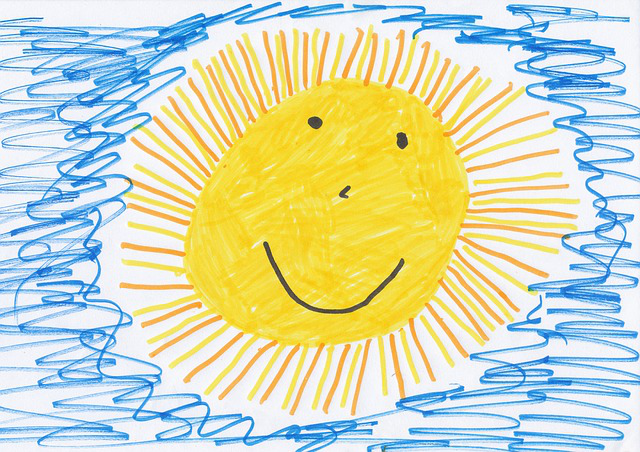

In [40]:
i = 0
for image in images:
    colours = getColoursForImageByClusters2(image)
    display(image)
    i+=1
    if(i>=5):
        break

In [74]:
hues

for image in images:
    img = image.copy().resize((150, 150)).convert('HSV')      # optional scale, to reduce time
    ar = np.array(img)
    shape = ar.shape
    ar = ar.reshape(scipy.product(shape[:2]), shape[2])
    
    print(ar)
    break
#     Find a way to limit these per image without sacrificing the maximums in the detail
#     Finding maximums, or _clustering_!
    

[[[233   3 166]
  [233   3 167]
  [233   3 167]
  ..., 
  [198   4 173]
  [198   4 172]
  [198   4 172]]

 [[233   3 167]
  [233   3 167]
  [233   3 168]
  ..., 
  [198   4 173]
  [198   4 172]
  [198   4 172]]

 [[233   3 168]
  [233   3 168]
  [233   3 169]
  ..., 
  [198   4 173]
  [198   4 172]
  [198   4 172]]

 ..., 
 [[  7  17 178]
  [  3  16 175]
  [  3  15 177]
  ..., 
  [205   8 174]
  [221   7 172]
  [221   7 171]]

 [[  3 115  75]
  [  3 109  79]
  [  3  99  87]
  ..., 
  [  0  21 164]
  [  2  24 155]
  [  7  29 148]]

 [[ 16 186 111]
  [ 17 179 112]
  [ 17 184 109]
  ..., 
  [ 13 172 105]
  [ 15 177 105]
  [ 15 177 105]]]
[[233   3 166]
 [233   3 167]
 [233   3 167]
 ..., 
 [ 13 172 105]
 [ 15 177 105]
 [ 15 177 105]]


In [153]:
#concatenate found colours of all images into one
allColours = sum(imgColours)

In [182]:
import colorsys
import math

# box 160, because center or circle = 100 => +/- 50 => + r of colour circle (max: 10) => 160
svg = '<svg viewBox="-160 -160 320 320" xmlns="http://www.w3.org/2000/svg">'

radius = 100

for colour in allColours:
    rgb, percentage = colour
    rgbNorm = rgb/255
    hsv = colorsys.rgb_to_hsv(rgbNorm[0], rgbNorm[1], rgbNorm[2])
    # find position on circle
    radians = 2 * math.pi * hsv[0]
    x = math.cos(radians)
    y = math.sin(radians)
    
    # based on saturation, we move inwards/outwards
    # min = 0.5, max = 1.5 (dus + 0.5)
    pos = np.array([x,y]) * (0.5 + hsv[1]) * radius
    # Posibilitiy: determine position based on avg(saturation, value) => dark & grey inside, shiney and colourful outside 
    # pos = np.array([x,y]) * (0.5 + (hsv[1]+hsv[2])/2) * radius
    r = max(1,-10/percentage+10) # as r, we converge to maximum radius 10, but don't want to get smaller radi then 1
    c = '<circle cx="%s" cy="%s" r="%s" style="fill:%s" />' % (pos[0], pos[1], r, getColourAsHex(rgb))
    svg += c

svg += "</svg>"

print (svg)

<svg viewBox="-160 -160 320 320" xmlns="http://www.w3.org/2000/svg"><circle cx="-51.7001271219" cy="38.030374836" r="1.99288256228" style="fill:#2d3530" /><circle cx="-34.4049859725" cy="-88.1541524636" r="2.69480519481" style="fill:#322d51" /><circle cx="55.1844093851" cy="-14.8880599213" r="1" style="fill:#9e9295" /><circle cx="64.1409867305" cy="-11.6760039413" r="1" style="fill:#947d81" /><circle cx="-53.8799118995" cy="-6.67364078148" r="1" style="fill:#aeb5b6" /><circle cx="49.8265732445" cy="63.0938334354" r="1" style="fill:#b9b281" /><circle cx="85.6164653701" cy="-5.97282016149" r="1" style="fill:#a2686c" /><circle cx="-67.7806952611" cy="-57.1290473968" r="1" style="fill:#56688c" /><circle cx="-94.2199518224" cy="-85.5727574281" r="3.38235294118" style="fill:#1a3472" /><circle cx="97.9360437597" cy="99.0421921816" r="2.64705882353" style="fill:#a58111" /><circle cx="136.682664482" cy="30.1582894959" r="1" style="fill:#a32e10" /><circle cx="-72.9827896955" cy="-67.1111153809" 

In [228]:
import json

def coloursToJson(colours):
    colours2 = [(list(colour[0]), colour[1]) for colour in colours]
    return json.dumps(colours2)

def jsonToColours(string):
    data = json.loads(string)
    return [(np.array(d[0]), d[1]) for d in data]


In [229]:
from peewee import *
from playhouse.sqlite_ext import SqliteExtDatabase
import datetime

class ColoursField(TextField):
#     db_field = 'colour'

    def db_value(self, value):
        return coloursToJson(value)

    def python_value(self, value):
        return jsonToColours(value) # convert str to UUID

db = SqliteExtDatabase('images.db')

class BaseModel(Model):
    class Meta:
        database = db
        
class Emotion(BaseModel):
    name = CharField(unique=True)
        
class Group(BaseModel):
    name = CharField(unique=True)

class Artwork(BaseModel):
    author = CharField()
    age = SmallIntegerField(index=True)
    gender = FixedCharField(max_length=1) # we should not really use this one
    group = ForeignKeyField(Group, related_name='artworks', index=True)
    emotion = ForeignKeyField(Emotion, related_name='artworks', index=True)
    created_date = DateTimeField(default=datetime.datetime.now)
    filename = CharField()
    colours = ColoursField() # serialised colours + percentages: [([r,g,b], percentage), ...]

db.connect()
db.create_tables([Emotion, Group, Artwork])

In [230]:
import random
from PIL import Image

emos = ["anger","contempt","disgust","fear","joy","sadness","surprise"]
emotions = []
for emo in emos:
    emotion = Emotion(name=emo)
    emotion.save()
    emotions.append(emotion)

# # Generate some random data:
for i in range(4,8):
    group = Group.create(name='Groep %s' % i)
    group.save()
    
#     some images:
    for j in range(20):
        genders = ['m','f','u']
        img = Artwork()
        img.gender = random.choice(genders)
        img.author = "%s %s%s" %  (img.gender, i,j)
        img.age = i + 4 + random.choice([-1,0,0,0,0,1,1,2])
        img.group = group
        img.emotion = random.choice(emotions)
        img.filename = random.choice(files)
        img.colours = getColoursForImageByClusters(Image.open(img.filename))
        img.save()
        print(img.author)
    

# # No need to set `is_published` or `created_date` since they
# # will just use the default values we specified.
# Tweet.create(user=charlie, message='My first tweet')

m 40
u 41
f 42
f 43
u 44
u 45
f 46
f 47
m 48
f 49
m 410
m 411
f 412
m 413
m 414
f 415
f 416
u 417
f 418
m 419
f 50
f 51
m 52
f 53
u 54
f 55
u 56
f 57
u 58
m 59
u 510
f 511
u 512
m 513
u 514
u 515
u 516
u 517
f 518
m 519
m 60
f 61
f 62
f 63
m 64
m 65
f 66
u 67
f 68
u 69
u 610
m 611
m 612
f 613
m 614
f 615
u 616
u 617
f 618
m 619
u 70
u 71
f 72
f 73
m 74
u 75
m 76
f 77
f 78
u 79
f 710
f 711
u 712
f 713
f 714
u 715
f 716
m 717
m 718
u 719


'[[[179.9060773480663, 181.53867403314916, 182.0331491712707], 1.6088888888888888], [[141.23, 75.99, 98.315], 0.8888888888888888], [[160.1976149914821, 162.10732538330495, 155.62862010221465], 2.6933333333333334], [[152.99333333333334, 94.78, 148.60666666666665], 0.6622222222222223], [[193.77777777777777, 123.0, 168.3939393939394], 0.44], [[168.1039501039501, 170.13617463617464, 166.88149688149687], 4.275555555555556], [[177.01677852348993, 178.6778523489933, 178.19463087248323], 2.648888888888889], [[67.04918032786885, 77.21311475409836, 86.59016393442623], 0.5466666666666666], [[173.30769230769232, 146.56410256410257, 154.9102564102564], 0.3466666666666667], [[150.82228116710874, 93.60212201591511, 120.54111405835543], 1.6755555555555555], [[211.6315789473684, 184.57894736842104, 139.3684210526316], 0.1688888888888889], [[159.63188976377953, 164.77165354330708, 159.78543307086613], 2.2577777777777777], [[167.3994673768309, 170.4247669773635, 170.61517976031956], 3.3377777777777777], 